<h1>Algorithmen in der Algebra, Woche 1</h1>

In [27]:
import unittest
import random

In [2]:
#Input: (f,r), where:
#f is the function you want to test (between quotation marks),
#r is the list of inputs you want to test it on.
#Output: a list of times in seconds.
#Also displays a plot of this list.
from sage.misc.sage_timeit import sage_timeit
def my_timeit(f,r):
    for i in r:
        L=flatten([sage_timeit(f+'('+str(i)+')', globals(), preparse=True, number=1, repeat=1).series for i in r])
        list_plot(L).show()
        return L

<h2>Addition von nicht-negativen ganzen Zahlen</h2> 

In [3]:
b=10;

In [4]:
def strip_zeroes(z):
    zz=z[:] #Liste kopieren
    while len(zz)>0 and zz[0]==0:
        zz.pop(0)
    return zz

In [9]:
#Beispiel
strip_zeroes([0,0,1,2,0,4,0])

[1, 2, 0, 4, 0]

In [10]:
def addition(x,y):
    m = len(x)
    n = len(y)
    c = 0
    z = []
    for i in [0..max(m,n)]:
        if i < m:
            c = c + x[m-i-1]
        if i < n:
            c = c + y[n-i-1]
        z.insert(0,c%b)
        c = c//b
    z=strip_zeroes(z)
    return z

In [11]:
addition([8,4,3],[2,7,9])

[1, 1, 2, 2]

In [12]:
addition([3,8],[3,8,0])

[4, 1, 8]

<h2>Langsame Multiplikation von zwei Zahlen</h2>

In [13]:
def slow_times(x,y):
    z=[]
    m=len(x)
    for i in range(m):
        for j in range(x[m-i-1]):
            z=addition(z,y+(i*[0])) #Extra Nullen, da wir mit b^i multiplizieren müssen.
    z=strip_zeroes(z)
    return z

In [14]:
slow_times([2,1],[3,8])

[7, 9, 8]

In [15]:
def slow_times_test(n): #berechnet das Produkt von zwei Zahlen der Länge n.
    return slow_times([randint(0,9) for i in range(n)],[randint(0,9) for i in range(n)])

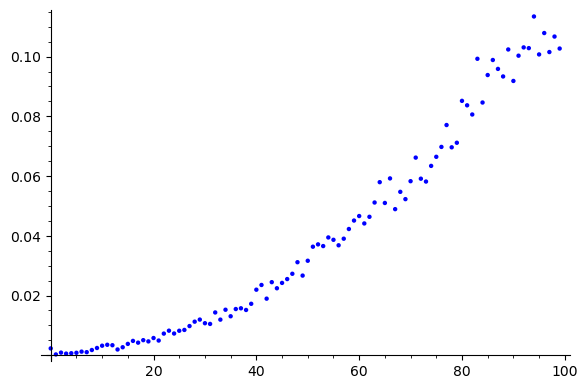

In [16]:
my_timeit('slow_times_test',[1..100]);

Man sieht das quadratische Verhalten.

In [17]:
#Liste zu Zahl. Kannst du als "black box" verwenden.
def liste_zu_zahl(numList):
    s = ''.join([str(i) for i in numList]) #Example what "join" does: '.'.join(['ab', 'pq', 'rs']) -> 'ab.pq.rs'
    return int(s)

In [18]:
#Beispiel
liste_zu_zahl([5,3,1])

531

In [33]:
def digits(x):
    return strip_zeroes([int(c) for c in str(x)])

In [19]:
def usual_times_test(n): #berechnet das Produkt von zwei Zahlen der Länge n.
    return liste_zu_zahl([randint(0,9) for i in range(n)])*liste_zu_zahl([randint(0,9) for i in range(n)])

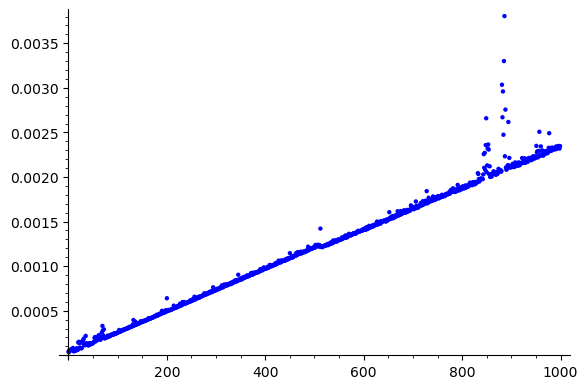

In [20]:
my_timeit('usual_times_test',[1..1000]);

Nicht nur ist die eingebaute Sage-Funktion Times viel schneller als SlowTimes; auch scheint das Verhalten gar nicht quadratisch.

<h2>Karatsuba</h2>

Implementieren Sie eine Funktion Subtraktion, ähnlich wie Addition, wo die Voraussetzung ist, dass die von x dargestellte Zahl groesser ist als die von y dargestellte Zahl (so dass keine neuen Symbole für negative Zahlen benötigt werden).

In [23]:
def subtract(x, y):
    m = len(x)
    n = len(y)
    
    c = 0
    z = []
    # Subtracting two values will certainly not cause the number of digits
    # to increase, simplifying this compared to addition.
    for i in [1..max(m,n)]:
        if i <= m:
            c = c + x[-i]
        if i <= n:
            c = c - y[-i]
        z.insert(0, c % b)
        c = c // b
        
    z = strip_zeroes(z)
    
    # x was less than y, so was an invalid input tuple
    if c < 0:
        raise ValueError("x may not be smaller than y")
    
    return z

In [39]:
class TestSubtract(unittest.TestCase):

    def test_valid_subtract(self):
        self.assertEqual(subtract([1, 2, 3], [4, 5]), [7, 8])
        self.assertEqual(subtract([4, 2, 7, 7], [2, 8, 9, 4]), [1, 3, 8, 3])
        self.assertEqual(subtract([4, 2], [4, 2]), [])

        # Let's add some non-determinism to tests. What could go wrong. (:
        for i in range(10000):
            x = random.randint(0, 10000)
            y = random.randint(0, x)
            z = x - y
            self.assertEqual(subtract(digits(x), digits(y)), digits(z))
        
    def test_invalid_subtract(self):
        # First argument must be larger than second
        with self.assertRaises(ValueError):
            subtract([4, 5], [1, 2, 3])
        
result = unittest.main(argv=[''], exit = False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.286s

OK


Implementieren Sie den Algorithmus von Karatsuba, indem Sie eine Funktion schreiben, die bei Input zwei Listen von Zahlen in [0,...,b-1] die Liste zurückgibt, die das Produkt darstellt. Sie sollten dabei die Funktion addition und ihre eigene Funktion subtraktion benutzen. Sobald die Zahlen zu klein sind (vielleicht Länge < 6, experimentieren Sie!), sollen Sie statt Rekursion zu benutzen die Funktion slow_times benutzen. Zeigen Sie mit my_timeit das Verhalten Ihrer Funktion bis Zahlen der Grösse 100 oder 200. Hoffentlich ist ihre Funktion schneller als slow_times!